In [5]:
import splitfolders

input_folder = r"C:\Users\admin\OneDrive\BE project\EyeProject\half data"
output_folder = r"C:\Users\admin\OneDrive\BE project\EyeProject\half data-split"

splitfolders.ratio(input_folder, output_folder, seed=42, ratio=(0.7, 0.2, 0.1))

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_data_dir=r"dataset\train"
val_data_dir=r"dataset\val"
test_data_dir=r"dataset\test"

from keras.layers.preprocessing.image_preprocessing import HORIZONTAL

train_datagen=ImageDataGenerator(
                                 horizontal_flip=True,
                                 )

val_datagen=ImageDataGenerator()
test_datagen=ImageDataGenerator()

img_width,img_height=224,224
batch_size=16
train_generator=train_datagen.flow_from_directory(train_data_dir,
                                                  target_size=(img_height,img_width),
                                                  batch_size=batch_size,
                                                  class_mode='categorical')

val_generator=val_datagen.flow_from_directory(val_data_dir,
                                              target_size=(img_height,img_width),
                                              batch_size=batch_size,
                                              class_mode='categorical')

test_generator=test_datagen.flow_from_directory(test_data_dir,
                                              target_size=(img_height,img_width),
                                              batch_size=batch_size,
                                              class_mode='categorical')

train_class_names = set()
num_train_samples=0
for i in train_generator.filenames:
    train_class_names.add(i.split('\\')[0])
    num_train_samples+=1
print(num_train_samples)
train_class_names

val_class_names = set()
num_val_samples=0
for i in val_generator.filenames:
    val_class_names.add(i.split('\\')[0])
    num_val_samples+=1
print(num_val_samples)
print(val_class_names)

num_classes = len(val_class_names)
num_classes

Found 4314 images belonging to 5 classes.
Found 536 images belonging to 5 classes.
Found 545 images belonging to 5 classes.
4314
536
{'cataract', 'AMD', 'normal', 'diabetic_retinopathy', 'glaucoma'}


5

In [3]:
from tensorflow.keras import regularizers
from tensorflow.keras.applications import EfficientNetV2B2
from tensorflow.keras.models import Model
from keras.layers import GlobalAveragePooling2D,Conv2D, Flatten, BatchNormalization, Dense, Dropout
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D
base_model = EfficientNetV2B2(
                    input_shape=(224, 224, 3),
                    weights='imagenet',
                    include_top=False,
                    include_preprocessing=True,
                    )

base_model.summary()

Model: "efficientnetv2-b2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  0           ['rescaling[0][0]']              
                                                                                                  
 stem_conv (Conv2D)             (None, 112, 112, 32  864         ['normalization[0

In [4]:
for layer in base_model.layers[:10]:
    layer.trainable = False
x = base_model.output
x = Conv2D(256,(3,3),activation='relu')(x)
x = Conv2D(128,(3,3),activation='relu')(x)
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu',kernel_regularizer=regularizers.l2(0.01))(x)
x = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(0.4)(x)
predictions = Dense(num_classes, activation='softmax')(x)
model1 = Model(inputs=base_model.inputs, outputs=predictions)

In [5]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf
checkpoint = ModelCheckpoint("EfficientNetV2B2.h5",
                             monitor='val_loss',
                             mode='min',
                             save_best_only=True,verbose=1)

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True)

callbacks=[checkpoint,earlystop]

epochs=20

In [6]:
model1.compile(loss='categorical_crossentropy',
                   optimizer=RMSprop(learning_rate=0.0001),
                   metrics=['accuracy', tf.keras.metrics.AUC()])
history1 = model1.fit(train_generator,
                         steps_per_epoch=num_train_samples//batch_size,
                         epochs=epochs,
                         callbacks=callbacks,
                         validation_data=val_generator,
                         validation_steps=num_val_samples//batch_size)

Epoch 1/20
269/269 [==============================] - ETA: 0s - loss: 4.0979 - accuracy: 0.7103 - auc: 0.9176
Epoch 1: val_loss improved from inf to 3.01017, saving model to radha_EfficientNetB2.h5
269/269 [==============================] - 69s 202ms/step - loss: 4.0979 - accuracy: 0.7103 - auc: 0.9176 - val_loss: 3.0102 - val_accuracy: 0.8769 - val_auc: 0.9842
Epoch 2/20
269/269 [==============================] - ETA: 0s - loss: 2.6198 - accuracy: 0.8497 - auc: 0.9744
Epoch 2: val_loss improved from 3.01017 to 2.08981, saving model to radha_EfficientNetB2.h5
269/269 [==============================] - 53s 196ms/step - loss: 2.6198 - accuracy: 0.8497 - auc: 0.9744 - val_loss: 2.0898 - val_accuracy: 0.8920 - val_auc: 0.9876
Epoch 3/20
269/269 [==============================] - ETA: 0s - loss: 1.8156 - accuracy: 0.8879 - auc: 0.9856
Epoch 3: val_loss improved from 2.08981 to 1.57116, saving model to radha_EfficientNetB2.h5
269/269 [==============================] - 53s 195ms/step - loss: 

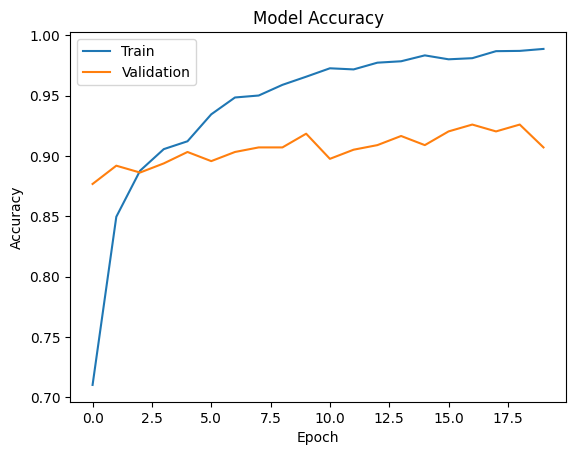

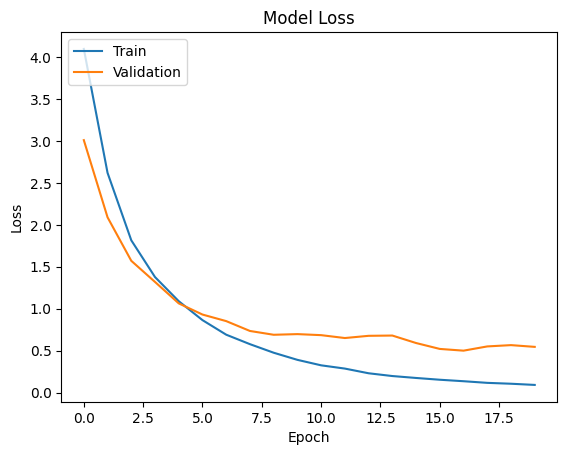

In [7]:
history = history1
import os
from matplotlib import pyplot as plt
# Plotting the accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Saving the accuracy plot
if not os.path.exists('graphs'):
    os.makedirs('graphs')
plt.savefig('graphs/EfficientNet accuracy.png')

# Plotting the loss
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Saving the loss plot
if not os.path.exists('graphs'):
    os.makedirs('graphs')
plt.savefig('graphs/EfficientNet loss.png')

In [8]:
evaluation = model1.evaluate(test_generator)

35/35 [==============================] - 7s 210ms/step - loss: 0.3900 - accuracy: 0.9211 - auc: 0.9867
